# 05 - City Tax Burden

Calculate per-capita tax burden for the top 100 US cities.

**Metrics:**
- City tax revenue per capita (from Census of Governments data)

**Data source:** Census Local Government Finances (embedded fallback)

**Output:** `city_tax_burden.csv`, `city_tax_burden.json`

In [1]:
import sys, json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

sys.path.insert(0, str(Path("..").resolve()))
from src.city_data_utils import get_top_100_cities, fetch_city_tax_revenue, get_city_col_weights

PROCESSED_DIR = Path("../data/processed")
CHARTS_DIR = Path("../docs/charts/data")
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
CHARTS_DIR.mkdir(parents=True, exist_ok=True)

# Load city data
cities = get_top_100_cities()
print(f"{len(cities)} cities loaded")
cities.head()

100 cities loaded


,city,city_state,state,population,lat,lon
0,New York,"New York, NY",NY,8258035,40.7128,-74.0060
1,Los Angeles,"Los Angeles, CA",CA,3820914,34.0522,-118.2437
2,Chicago,"Chicago, IL",IL,2665039,41.8781,-87.6298
3,Houston,"Houston, TX",TX,2314157,29.7604,-95.3698
4,Phoenix,"Phoenix, AZ",AZ,1650070,33.4484,-112.0740


In [2]:
# Fetch tax revenue per capita
tax = fetch_city_tax_revenue()

# Merge with city data
burden = cities.merge(tax, on="city_state", how="inner")

print(f"Cities with tax data: {len(burden)}")
print(f"Tax per capita range: ${burden['tax_per_capita'].min():,.0f} \u2013 ${burden['tax_per_capita'].max():,.0f}")
print(f"Median: ${burden['tax_per_capita'].median():,.0f}")

# Display top/bottom
display_df = burden[["city_state", "population", "tax_per_capita"]].copy()
display_df["population"] = display_df["population"].apply(lambda x: f"{x:,.0f}")
display_df["tax_per_capita"] = burden["tax_per_capita"].apply(lambda x: f"${x:,.0f}")
display_df.sort_values("city_state").head(10)

Using embedded city tax revenue data
Cities with tax data: 100
Tax per capita range: $567 – $6,245
Median: $1,345


,city_state,population,tax_per_capita
30,"Albuquerque, NM","564,559","$1,098"
53,"Anaheim, CA","350,986","$1,234"
47,"Arlington, TX","394,266",$987
35,"Atlanta, GA","510,823","$2,345"
51,"Aurora, CO","395,282",$987
10,"Austin, TX","979,882","$1,467"
49,"Bakersfield, CA","413,280",$765
28,"Baltimore, MD","585,708","$3,234"
92,"Baton Rouge, LA","225,128","$1,567"
88,"Boise, ID","237,446","$1,098"


In [3]:
# --- Cost-of-living adjustment ---
city_col = get_city_col_weights()
burden = burden.merge(city_col, on="city_state", how="left")
burden["tax_per_capita"] = burden["tax_per_capita"] * burden["col_weight"]

print(f"COL-adjusted tax per capita range: ${burden['tax_per_capita'].min():,.0f} – ${burden['tax_per_capita'].max():,.0f}")

# Export to CSV and JSON
export_cols = ["city", "city_state", "state", "population", "lat", "lon",
               "tax_per_capita", "rpp", "col_weight"]
out = burden[export_cols].sort_values("city_state").reset_index(drop=True)

csv_path = PROCESSED_DIR / "city_tax_burden.csv"
out.to_csv(csv_path, index=False)
print(f"Wrote {csv_path}")

json_path = CHARTS_DIR / "city_tax_burden.json"
out.to_json(json_path, orient="records", indent=2)
print(f"Wrote {json_path}")

COL-adjusted tax per capita range: $436 – $4,625
Wrote ../data/processed/city_tax_burden.csv
Wrote ../docs/charts/data/city_tax_burden.json


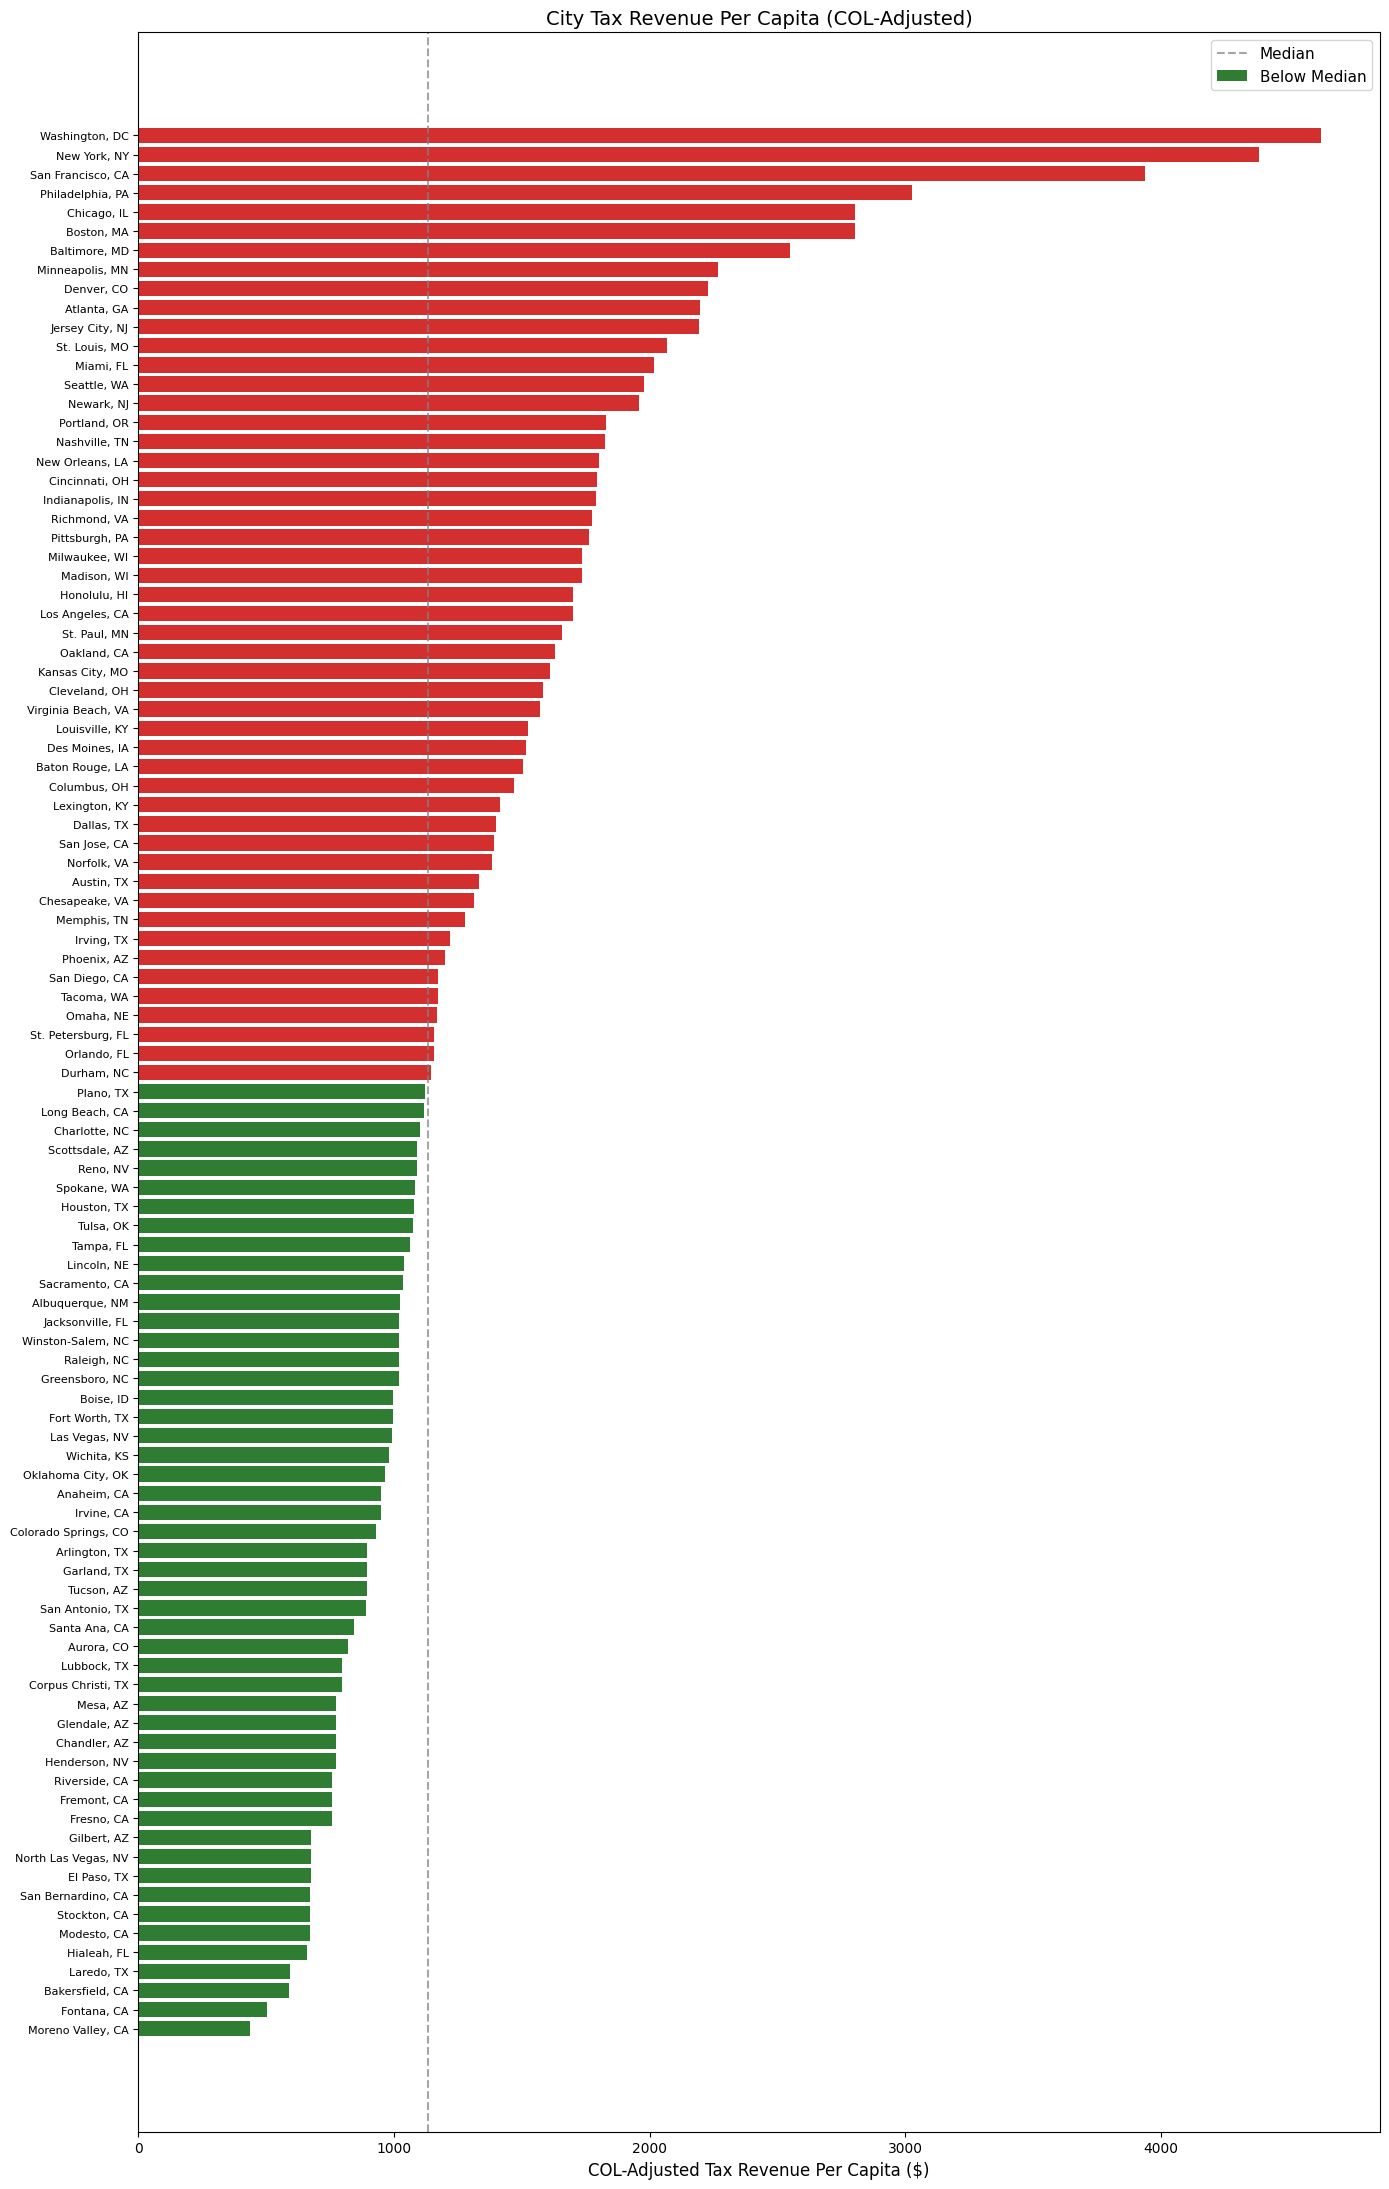

In [4]:
# Visualization — Per-capita city tax revenue (COL-adjusted)
fig, ax = plt.subplots(figsize=(14, 22))
plot_data = out.sort_values("tax_per_capita", ascending=True)
median_tax = plot_data["tax_per_capita"].median()
colors = ["#2e7d32" if v <= median_tax else "#d32f2f" for v in plot_data["tax_per_capita"]]
ax.barh(plot_data["city_state"], plot_data["tax_per_capita"], color=colors)
ax.set_xlabel("COL-Adjusted Tax Revenue Per Capita ($)", fontsize=12)
ax.set_title("City Tax Revenue Per Capita (COL-Adjusted)", fontsize=14)
ax.axvline(x=median_tax, color="gray", linestyle="--", alpha=0.7, label="Median")
ax.tick_params(axis="y", labelsize=8)
ax.legend(["Median", "Below Median", "Above Median"], fontsize=11)
plt.tight_layout()
plt.show()

In [5]:
import plotly.express as px

SCORE_SCALE = [[0, "#2e7d32"], [0.25, "#66bb6a"], [0.5, "#fdd835"], [0.75, "#ff9800"], [1, "#d32f2f"]]

fig = px.scatter_geo(
    out,
    lat="lat",
    lon="lon",
    color="tax_per_capita",
    size="population",
    color_continuous_scale=SCORE_SCALE,
    scope="usa",
    hover_name="city_state",
    hover_data={
        "lat": False,
        "lon": False,
        "tax_per_capita": ":$,.0f",
        "population": ":,.0f",
    },
    labels={
        "tax_per_capita": "Tax/Capita ($)",
        "population": "Population",
    },
    title="City Tax Revenue Per Capita (green=lower, red=higher)",
    size_max=30,
)
fig.update_layout(
    coloraxis_colorbar=dict(title="$/Capita"),
    geo=dict(lakecolor="rgb(255,255,255)"),
)
fig.show()